# Análisis de Series Temporales: Stock y Ventas de Donuts

En este notebook se realizará un análisis completo de datos sintéticos de una tienda de donuts. Se cubrirán los siguientes aspectos:

- **Generación de datos sintéticos:** Simulación de ventas, stock, reabastecimiento y otros indicadores diarios.
- **Tratamiento de datos temporales:** Conversión de fechas, indexación, extracción de características temporales.
- **Análisis de componentes de la serie:** Señal, ruido, estacionalidad y ciclos.
- **Detección y tratamiento de autocorrelación:** Uso de ACF y PACF para identificar dependencias temporales.
- **Modelado con ARIMA y modelos de regresión:** Ajuste de modelos clásicos de series temporales y enfoque basado en regresión con variables temporales.
- **Comparación de Resultados:** Evaluación de métricas (por ejemplo, RMSE) y discusión de ventajas y limitaciones de cada método.

¡Empecemos!

In [5]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Para series temporales y modelos
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Para modelos de regresión
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Para reproducibilidad
np.random.seed(42)

## 1. Generación de Datos Sintéticos para la Tienda de Donuts

Simularemos datos diarios de un año para una tienda de donuts, que incluirán:

- **Fecha**: Rango diario.
- **Stock_inicial**: Cantidad de donuts al inicio del día.
- **Ventas**: Número de donuts vendidos (con mayor actividad en fines de semana).
- **Reabastecimiento**: Cantidad de donuts añadidos cuando el stock baja de cierto nivel.
- **Stock_final**: Stock al cierre del día.

También se introducirán variaciones para simular estacionalidad, ciclos y ruido.

In [6]:
# Parámetros de la simulación
fecha_inicio = '2023-01-01'
fecha_fin = '2023-12-31'
fechas = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='D')
n_dias = len(fechas)

# Parámetros base
stock_inicial_base = 100  
promedio_ventas = 20
variabilidad_ventas = 5

# Simulación de ventas: mayor actividad en fines de semana y un poco de tendencia estacional (aumento leve en verano)
ventas = []
for i, fecha in enumerate(fechas):
    dia_semana = fecha.weekday()  # 0 = lunes, 6 = domingo
    # Factor estacional: +50% en fines de semana
    factor_estacional = 1.5 if dia_semana in [5, 6] else 1.0
    # Tendencia: aumento leve en ventas durante el verano (meses 6-8)
    factor_tendencia = 1.2 if fecha.month in [6,7,8] else 1.0
    venta = np.random.normal(loc=promedio_ventas * factor_estacional * factor_tendencia,
                             scale=variabilidad_ventas)
    ventas.append(max(0, int(round(venta))))

ventas = np.array(ventas)

# Generar datos diarios de stock y reabastecimiento
stock_inicial_list = []
stock_final_list = []
reabastecimiento = []

stock = stock_inicial_base
nivel_reabastecimiento = 30
cantidad_reabastecimiento = 50

for venta in ventas:
    stock_inicial_list.append(stock)
    # Ventas del día, no pueden superar el stock disponible
    venta_real = min(stock, venta)
    stock -= venta_real
    if stock < nivel_reabastecimiento:
        reab = cantidad_reabastecimiento
        stock += reab
    else:
        reab = 0
    stock_final_list.append(stock)
    reabastecimiento.append(reab)

# Crear DataFrame
df = pd.DataFrame({
    'Fecha': fechas,
    'Stock_inicial': stock_inicial_list,
    'Ventas': ventas,
    'Reabastecimiento': reabastecimiento,
    'Stock_final': stock_final_list
})

df['Fecha'] = pd.to_datetime(df['Fecha'])
df.set_index('Fecha', inplace=True)

print(df.head())

            Stock_inicial  Ventas  Reabastecimiento  Stock_final
Fecha                                                           
2023-01-01            100      32                 0           68
2023-01-02             68      19                 0           49
2023-01-03             49      23                50           76
2023-01-04             76      28                 0           48
2023-01-05             48      19                50           79


## 2. Análisis de Componentes de la Serie

Descomponemos la serie de ventas para identificar:
- **Tendencia**: Comportamiento a largo plazo.
- **Estacionalidad**: Patrones periódicos (por ejemplo, variaciones semanales).
- **Ruido**: Variabilidad no explicada.

Utilizaremos la función `seasonal_decompose` de *statsmodels*.

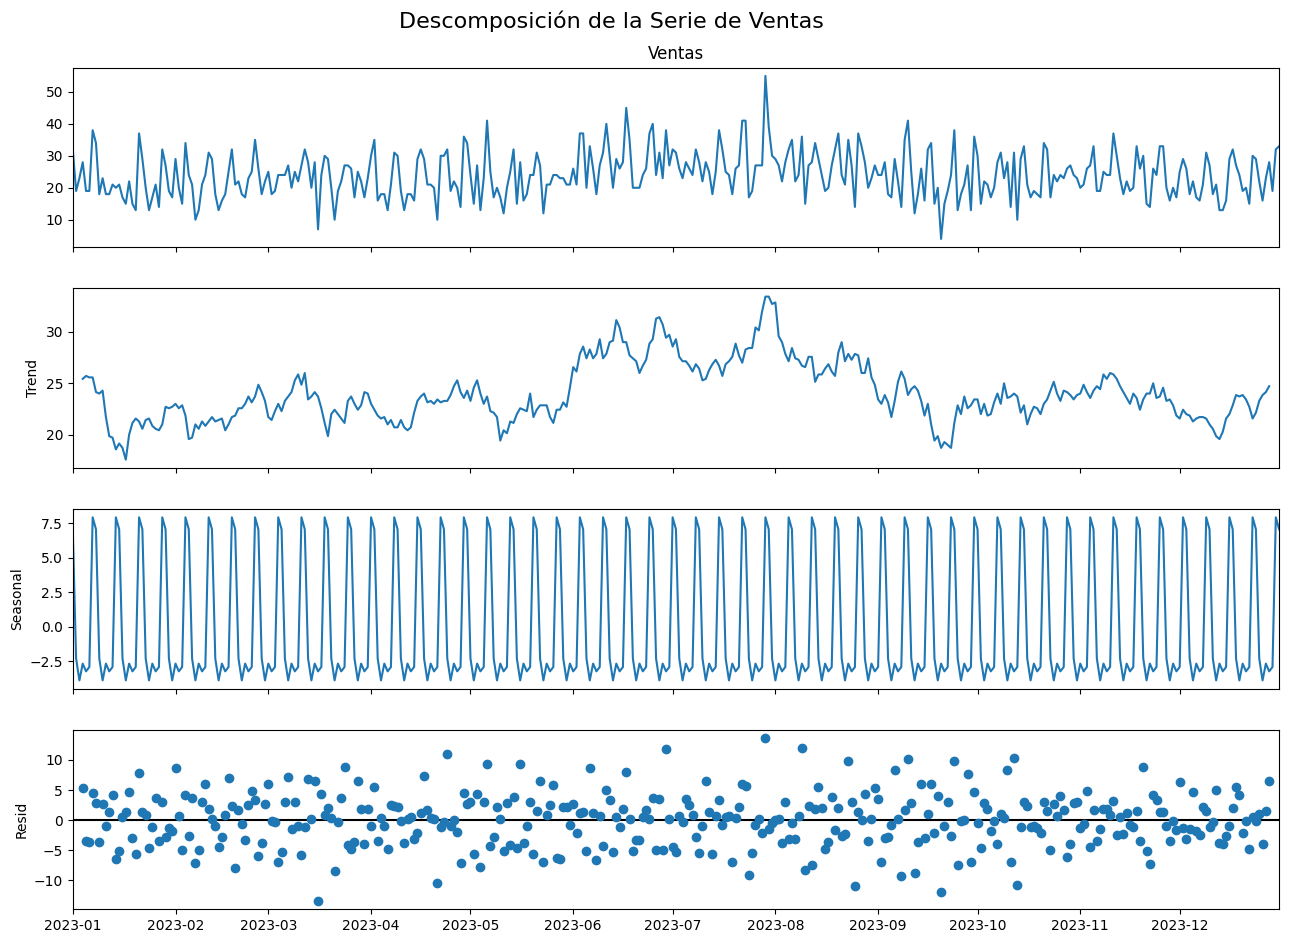

In [7]:
# Descomposición de la serie de ventas
result = seasonal_decompose(df['Ventas'], model='additive', period=7)  

# Graficar la descomposición
fig = result.plot()
fig.set_size_inches(14, 10)
plt.suptitle('Descomposición de la Serie de Ventas', fontsize=16)
plt.show()

## 3. Detección y Tratamiento de Autocorrelación

Para determinar si la serie tiene autocorrelación, se utilizan las gráficas de ACF y PACF. Estas gráficas permiten identificar lags significativos, lo cual es útil para el modelado con ARIMA.

A continuación se muestran las gráficas de autocorrelación (ACF) y autocorrelación parcial (PACF).

<Figure size 1200x500 with 0 Axes>

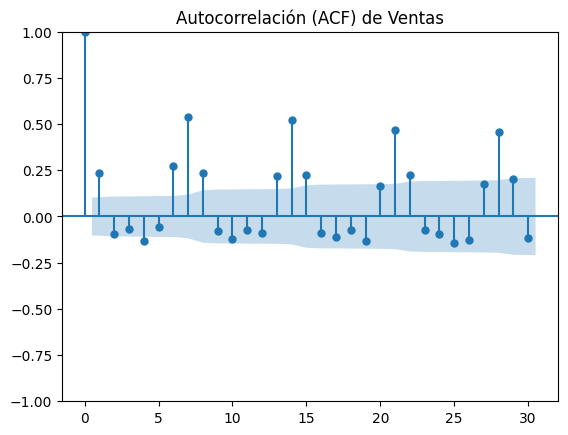

<Figure size 1200x500 with 0 Axes>

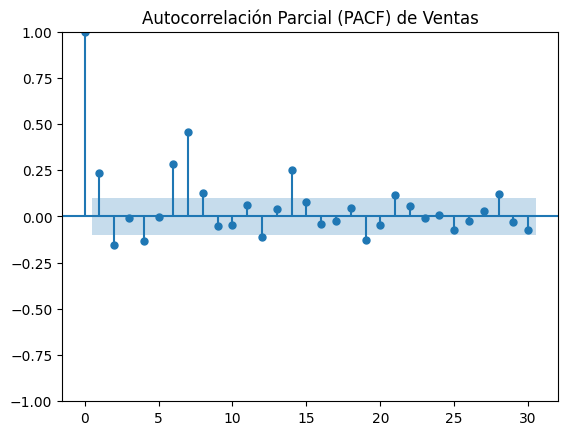

In [8]:
plt.figure(figsize=(12,5))
plot_acf(df['Ventas'], lags=30)
plt.title('Autocorrelación (ACF) de Ventas')
plt.show()

plt.figure(figsize=(12,5))
plot_pacf(df['Ventas'], lags=30, method='ywm')
plt.title('Autocorrelación Parcial (PACF) de Ventas')
plt.show()

## 4. Modelado de la Serie: ARIMA y Regresión

Se aplicarán dos enfoques para pronosticar las ventas:

1. **Modelo ARIMA:**
   - Ajuste de un modelo ARIMA para capturar la dinámica temporal de la serie.
   - Pronóstico a futuro y evaluación del error.

2. **Modelo de Regresión con Variables Temporales:**
   - Creación de features a partir de la fecha (por ejemplo, día de la semana, lags).
   - Ajuste de un modelo de regresión lineal.
   - Comparación de resultados con el modelo ARIMA.

Finalmente, se compararán ambos modelos usando la métrica RMSE.

c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Ventas   No. Observations:                  292
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -987.282
Date:                Wed, 19 Feb 2025   AIC                           1986.564
Time:                        12:17:18   BIC                           2008.624
Sample:                    01-01-2023   HQIC                          1995.400
                         - 10-19-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.2063      0.523     46.287      0.000      23.181      25.231
ar.L1         -0.5392     84.079     -0.006      0.995    -165.332     164.254
ar.L2         -0.0706     22.251     -0.003      0.9

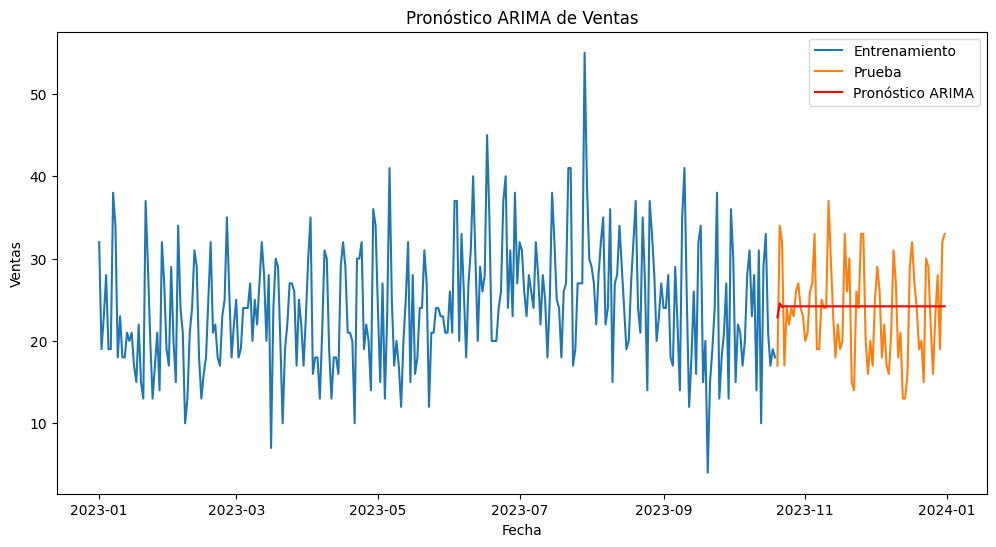

In [9]:
# Modelo ARIMA
from statsmodels.tsa.arima.model import ARIMA

# Dividimos la serie en entrenamiento y prueba (por ejemplo, 80% entrenamiento, 20% prueba)
train_size = int(0.8 * len(df))
train, test = df['Ventas'].iloc[:train_size], df['Ventas'].iloc[train_size:]

# Ajustamos un modelo ARIMA (los parámetros p, d, q se pueden seleccionar a partir de ACF/PACF)
model_arima = ARIMA(train, order=(2,0,2))
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

# Pronóstico para el período de prueba
forecast_arima = model_arima_fit.forecast(steps=len(test))

# Evaluación del modelo ARIMA
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima))
print(f"RMSE ARIMA: {rmse_arima:.2f}")

# Graficar el pronóstico
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Prueba')
plt.plot(test.index, forecast_arima, label='Pronóstico ARIMA', color='red')
plt.title('Pronóstico ARIMA de Ventas')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

RMSE Regresión: 4.98


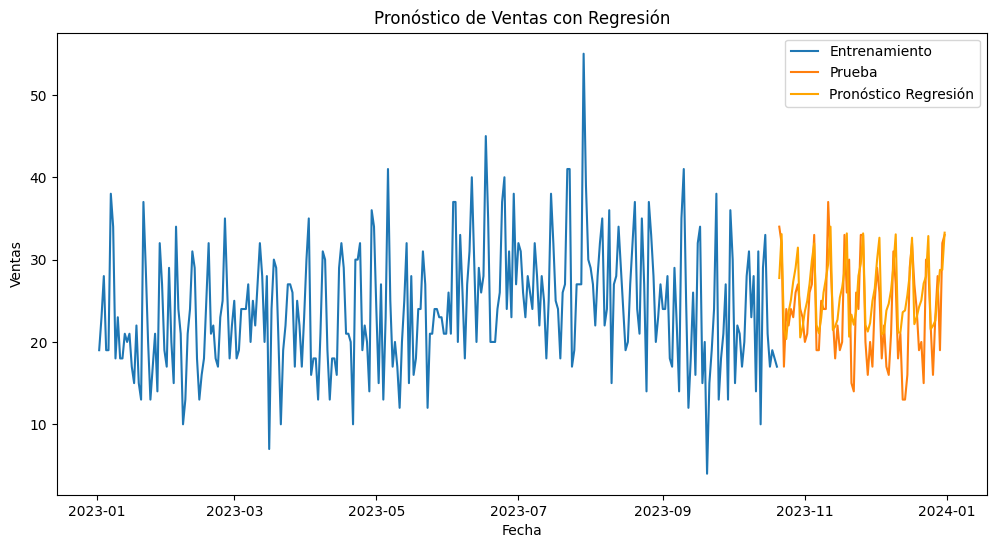

In [10]:
# Modelo de Regresión con Features Temporales

# Crear features a partir de la fecha
df_reg = df.copy()
df_reg['DiaSemana'] = df_reg.index.weekday
df_reg['Mes'] = df_reg.index.month

# Crear lag de ventas (por ejemplo, 1 día de retraso)
df_reg['Lag1'] = df_reg['Ventas'].shift(1)

# Eliminar los valores nulos generados por el lag
df_reg = df_reg.dropna()

# Dividir en entrenamiento y prueba
train_reg = df_reg.iloc[:train_size]
test_reg = df_reg.iloc[train_size:]

# Definir las variables predictoras y la variable objetivo
features = ['DiaSemana', 'Mes', 'Lag1']
X_train_reg = train_reg[features]
y_train_reg = train_reg['Ventas']
X_test_reg = test_reg[features]
y_test_reg = test_reg['Ventas']

# Ajustar un modelo de regresión lineal
model_reg = LinearRegression()
model_reg.fit(X_train_reg, y_train_reg)

# Pronóstico en el conjunto de prueba
forecast_reg = model_reg.predict(X_test_reg)
rmse_reg = np.sqrt(mean_squared_error(y_test_reg, forecast_reg))
print(f"RMSE Regresión: {rmse_reg:.2f}")

# Graficar el pronóstico de la regresión
plt.figure(figsize=(12,6))
plt.plot(train_reg.index, y_train_reg, label='Entrenamiento')
plt.plot(test_reg.index, y_test_reg, label='Prueba')
plt.plot(test_reg.index, forecast_reg, label='Pronóstico Regresión', color='orange')
plt.title('Pronóstico de Ventas con Regresión')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

## 5. Comparación de Modelos y Conclusiones

Se muestran a continuación los RMSE obtenidos con los dos enfoques:

- **ARIMA:** El RMSE obtenido con el modelo ARIMA.
- **Regresión:** El RMSE obtenido con el modelo de regresión basado en features temporales.

La comparación de estas métricas junto con la inspección visual de los pronósticos permite decidir cuál modelo se ajusta mejor a la serie de ventas y, en consecuencia, cuál podría utilizarse para optimizar la gestión del stock de donuts en la tienda.

### Discusión

- ¿El modelo ARIMA captura correctamente la estacionalidad y la tendencia?
- ¿La regresión con variables de tiempo y lags es suficientemente robusta?
- ¿Qué mejoras se podrían implementar (por ejemplo, utilizar más lags, incluir variables adicionales, aplicar transformaciones, etc.)?

Estos análisis servirán como base para recomendaciones en la gestión del inventario y reposición de productos en la tienda de donuts.

## Ejercicio Final

Utilizando los conceptos y métodos vistos en este notebook, realiza lo siguiente:

1. **Explora** y **limpia** los datos sintéticos (o un dataset real, si lo dispones) de la tienda de donuts.
2. **Extrae** características temporales adicionales (por ejemplo, variables dummy para días festivos, ciclos mensuales, etc.).
3. **Ajusta** al menos dos modelos de pronóstico (puedes incluir modelos de machine learning adicionales) y evalúa su desempeño usando RMSE u otra métrica.
4. **Analiza** la autocorrelación de la serie y propone posibles estrategias para mitigarla en el modelado.
5. **Presenta** tus conclusiones y recomendaciones sobre cómo la tienda debería gestionar el stock de donuts en función de los pronósticos obtenidos.

¡Buena suerte!